In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tqdm
import matplotlib.pyplot as plt

In [3]:
# Check available CUDA devices and memory
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        total_mem = torch.cuda.get_device_properties(i).total_memory / 1024**3  # Convert to GB
        allocated_mem = torch.cuda.memory_allocated(i) / 1024**3  # Convert to GB
        free_mem = total_mem - allocated_mem
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {total_mem:.1f}GB")
        print(f"Allocated Memory: {allocated_mem:.1f}GB")
        print(f"Free Memory: {free_mem:.1f}GB")
        
        if free_mem < 8:
            print(f"Warning: GPU {i} has less than 8GB of free VRAM!")
        else:
            print(f"Using GPU {i} with {free_mem:.1f}GB free VRAM")
            break 
    device = torch.device(f"cuda:{i}")
else:
    print("Warning: No CUDA devices available - running on CPU only")
    device = torch.device("cpu")

GPU 0: NVIDIA GeForce RTX 4070 Ti
Total Memory: 12.0GB
Allocated Memory: 0.0GB
Free Memory: 12.0GB
Using GPU 0 with 12.0GB free VRAM


In [4]:
#df_train = pd.read_csv("community_data/community_1_train.csv")
#df_test = pd.read_csv("community_data/community_1_test.csv")

In [5]:
df = pd.read_csv("./community_data/community_1.csv")
df.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,Month,Season,is_weekend
0,1,2010-07-01 05:00:00,0.0,1.238,NaN,NaN,NaN,7,3,0
1,1,2010-07-01 05:30:00,0.0,0.247,NaN,NaN,NaN,7,3,0
2,1,2010-07-01 06:00:00,0.0,0.118,NaN,NaN,NaN,7,3,0
3,1,2010-07-01 06:30:00,0.0,0.108,NaN,NaN,NaN,7,3,0
4,1,2010-07-01 07:00:00,0.0,0.362,NaN,NaN,NaN,7,3,0


In [6]:
numerical_columns = ["NL", "NL_t-24", "NL_t-24*7", "NL_t-24*30"]
categorical_columns = ["Month", "Season"]
target_column = ["GG"]

# Apply data normalization [0, 1] for numerical columns
#scaler = MinMaxScaler()
#df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
#df_train[target_column] = scaler.fit_transform(df_train[target_column])

In [7]:
# Apply one-hot encoding for categorical columns
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df[categorical_columns])
df_encoded = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded.head()

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
df = pd.concat([df, df_encoded], axis=1)
df.drop(columns=categorical_columns, inplace=True)
df.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,is_weekend,Month_1,Month_2,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
0,1,2010-07-01 05:00:00,0.0,1.238,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2010-07-01 05:30:00,0.0,0.247,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2010-07-01 06:00:00,0.0,0.118,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,2010-07-01 06:30:00,0.0,0.108,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2010-07-01 07:00:00,0.0,0.362,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# Quick fix remove rows with NaN values
#df = df.dropna().reset_index(drop=True)
#df.head()

In [ ]:
# Apply interpolation to handle NaN values
#df["NL_t-24"] = df["NL_t-24"].interpolate(method='linear')
#df["NL_t-24*7"] = df["NL_t-24*7"].interpolate(method='linear')
#df["NL_t-24*30"] = df["NL_t-24*30"].interpolate(method='linear')
#df.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,is_weekend,Month_1,Month_2,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
0,1,2010-07-01 05:00:00,0.0,1.238,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2010-07-01 05:30:00,0.0,0.247,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2010-07-01 06:00:00,0.0,0.118,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,2010-07-01 06:30:00,0.0,0.108,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2010-07-01 07:00:00,0.0,0.362,NaN,NaN,NaN,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# Use forward and backward fill to handle NaN values
#df = df.fillna(method='ffill').fillna(method='bfill')
df = df.ffill().bfill()
df.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,is_weekend,Month_1,Month_2,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
0,1,2010-07-01 05:00:00,0.0,1.238,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2010-07-01 05:30:00,0.0,0.247,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2010-07-01 06:00:00,0.0,0.118,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,2010-07-01 06:30:00,0.0,0.108,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2010-07-01 07:00:00,0.0,0.362,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
df_train = df[df["datetime"] < "2012-07-01"]
df_test = df[df["datetime"] >= "2012-07-01"]

# Create a copy of the DataFrames to avoid modifying the original data
df_train = df_train.copy()
df_test = df_test.copy()

In [14]:
df_train.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,is_weekend,Month_1,Month_2,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
0,1,2010-07-01 05:00:00,0.0,1.238,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2010-07-01 05:30:00,0.0,0.247,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2010-07-01 06:00:00,0.0,0.118,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,2010-07-01 06:30:00,0.0,0.108,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2010-07-01 07:00:00,0.0,0.362,1.238,1.238,1.238,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
df_test.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,is_weekend,Month_1,Month_2,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
23392,1,2012-07-01 05:00:00,0.0,1.090,0.143,0.152,0.627,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23393,1,2012-07-01 05:30:00,0.0,0.657,0.666,0.641,0.658,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23394,1,2012-07-01 06:00:00,0.0,0.337,0.623,0.942,0.089,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23395,1,2012-07-01 06:30:00,0.0,0.048,0.250,0.698,0.074,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23396,1,2012-07-01 07:00:00,0.0,0.101,0.075,0.519,0.324,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Apply data normalization [0, 1] for numerical columns and target column
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()
df_train[numerical_columns] = scaler_input.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler_input.transform(df_test[numerical_columns])

df_train[target_column] = scaler_output.fit_transform(df_train[target_column])
df_test[target_column] = scaler_output.transform(df_test[target_column])

In [17]:
df_train.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,is_weekend,Month_1,Month_2,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
0,1,2010-07-01 05:00:00,0.0,0.469887,0.469887,0.469887,0.469887,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2010-07-01 05:30:00,0.0,0.382374,0.469887,0.469887,0.469887,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2010-07-01 06:00:00,0.0,0.370982,0.469887,0.469887,0.469887,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,2010-07-01 06:30:00,0.0,0.370099,0.469887,0.469887,0.469887,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2010-07-01 07:00:00,0.0,0.392529,0.469887,0.469887,0.469887,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
df_test.head()

,Customer,datetime,GG,NL,NL_t-24,NL_t-24*7,NL_t-24*30,is_weekend,Month_1,Month_2,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_1,Season_2,Season_3,Season_4
23392,1,2012-07-01 05:00:00,0.0,0.456817,0.373190,0.373984,0.415931,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23393,1,2012-07-01 05:30:00,0.0,0.418580,0.419375,0.417167,0.418668,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23394,1,2012-07-01 06:00:00,0.0,0.390321,0.415578,0.443748,0.368421,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23395,1,2012-07-01 06:30:00,0.0,0.364800,0.382639,0.422201,0.367096,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23396,1,2012-07-01 07:00:00,0.0,0.369481,0.367185,0.406394,0.389173,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
class SolarPV(Dataset):
    # Initialise dataset
    def __init__(self, df, seq_length):
        self.features = df.drop(columns=['Customer', 'datetime', 'GG']).values.astype('float32')
        self.targets = df['GG'].values.astype('float32')
        self.seq_length = seq_length

    # Return length of dataset
    def __len__(self):
        return len(self.features) - self.seq_length

    # Load and return item from dataset
    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.targets[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [20]:
class LSTMModel(nn.Module):
    # Define LSTM model
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    # Forward pass through the model
    # x: input tensor of shape (batch_size, seq_length, input_size)
    # Returns output tensor of shape (batch_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out.squeeze(1)

In [21]:
def train(model, dataloader, epochs, lr, device):
    # Define loss function and optimiser
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            pred = model(x_batch)

            # Compute loss
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

In [22]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)

            #preds.extend(pred.cpu().numpy())
            #targets.extend(y_batch.cpu().numpy())
            #preds.extend(pred.squeeze().numpy())
            #targets.extend(y_batch.squeeze().numpy())
            #preds.extend(pred.squeeze().cpu().numpy())
            #targets.extend(y_batch.squeeze().cpu().numpy())
            preds.extend(pred.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
            

    mae = mean_absolute_error(targets, preds)
    mse = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    #mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
    r2 = r2_score(targets, preds)
    print(f"R2 Score: {r2:.4f}")
    print(f"Evaluation - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    return preds, targets

In [23]:
# Create DataLoader for training data
train_dataset = SolarPV(df_train, seq_length=31)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for test data
test_dataset = SolarPV(df_test, seq_length=31)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset length
print(f"Total samples available: {len(train_dataset)}")

Total samples available: 1748929


In [24]:
# Retrieve first sample
x, y = train_dataset[0]

print("Input feature sequence shape:", x.shape)
print("GG value:", y)

Input feature sequence shape: torch.Size([31, 21])
GG value: tensor(0.)


In [25]:
for x_batch, y_batch in train_dataloader:
    print("Batch input feature shape:", x_batch.shape)
    print("Batch GG shape:", y_batch.shape)
    break  # Only print first batch

Batch input feature shape: torch.Size([32, 31, 21])
Batch GG shape: torch.Size([32])


In [26]:
# Test evaluate function
model = LSTMModel(input_size=train_dataset.features.shape[1], hidden_size=64, num_layers=2, output_size=1).to(device)
preds, targets = evaluate(model, test_dataloader, device)

preds_unscaled = scaler_output.inverse_transform(np.array(preds).reshape(-1, 1))
targets_unscaled = scaler_output.inverse_transform(np.array(targets).reshape(-1, 1))

mae = mean_absolute_error(targets_unscaled, preds_unscaled)
mse = mean_squared_error(targets_unscaled, preds_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(targets_unscaled, preds_unscaled)


# Calculate evaluation metrics
#mae = mean_absolute_error(targets, preds)
#mse = mean_squared_error(targets, preds)
#rmse = np.sqrt(mse)
#mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
#r2 = r2_score(targets, preds)

print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
print(f"MSE  (Mean Squared Error):       {mse:.4f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
#print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
print(f"R²   (Coefficient of Determination): {r2:.4f}")

R2 Score: -0.0118
Evaluation - MAE: 0.0480, MSE: 0.0050, RMSE: 0.0707
MAE  (Mean Absolute Error):      0.2119
MSE  (Mean Squared Error):       0.0976
RMSE (Root Mean Squared Error):  0.3124
R²   (Coefficient of Determination): -0.0118


In [27]:
#Initialise model
model = LSTMModel(input_size=train_dataset.features.shape[1], hidden_size=64, num_layers=2, output_size=1).to(device)
# Train the model
train(model, train_dataloader, epochs=10, lr=0.001, device=device)

Epoch [1/10], Loss: 0.0008
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0006
Epoch [4/10], Loss: 0.0005
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0005


In [28]:
preds, targets = evaluate(model, test_dataloader, device=device)

preds_unscaled = scaler_output.inverse_transform(np.array(preds).reshape(-1, 1))
targets_unscaled = scaler_output.inverse_transform(np.array(targets).reshape(-1, 1))

mae = mean_absolute_error(targets_unscaled, preds_unscaled)
mse = mean_squared_error(targets_unscaled, preds_unscaled)
rmse = np.sqrt(mse)
r2 = r2_score(targets_unscaled, preds_unscaled)

# Calculate evaluation metrics
#mae = mean_absolute_error(targets, preds)
#mse = mean_squared_error(targets, preds)
#rmse = np.sqrt(mse)
#mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
#r2 = r2_score(targets, preds)

print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
print(f"MSE  (Mean Squared Error):       {mse:.4f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
#print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
print(f"R²   (Coefficient of Determination): {r2:.4f}")


R2 Score: 0.8836
Evaluation - MAE: 0.0137, MSE: 0.0006, RMSE: 0.0240
MAE  (Mean Absolute Error):      0.0604
MSE  (Mean Squared Error):       0.0112
RMSE (Root Mean Squared Error):  0.1059
R²   (Coefficient of Determination): 0.8836


In [29]:
# Print length of predictions and targets
print(f"Number of predictions: {len(preds)}")
print(f"Number of targets: {len(targets)}")

Number of predictions: 871297
Number of targets: 871297


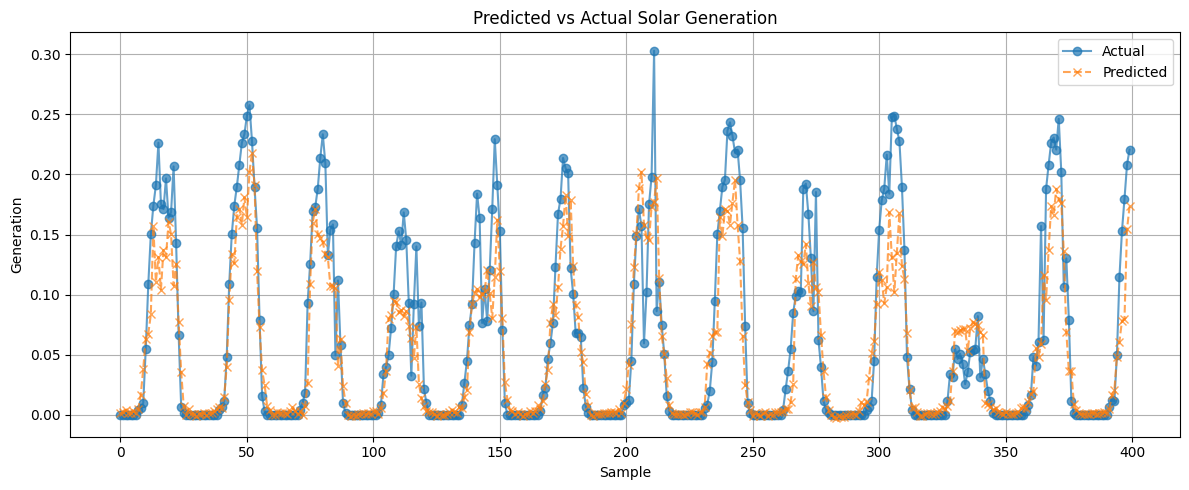

In [30]:
# Plot first 100 samples
plt.figure(figsize=(12, 5))
plt.plot(targets[:400], label='Actual', linestyle='-', marker='o', alpha=0.7)
plt.plot(preds[:400], label='Predicted', linestyle='--', marker='x', alpha=0.7)
plt.title("Predicted vs Actual Solar Generation")
plt.xlabel("Sample")
plt.ylabel("Generation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


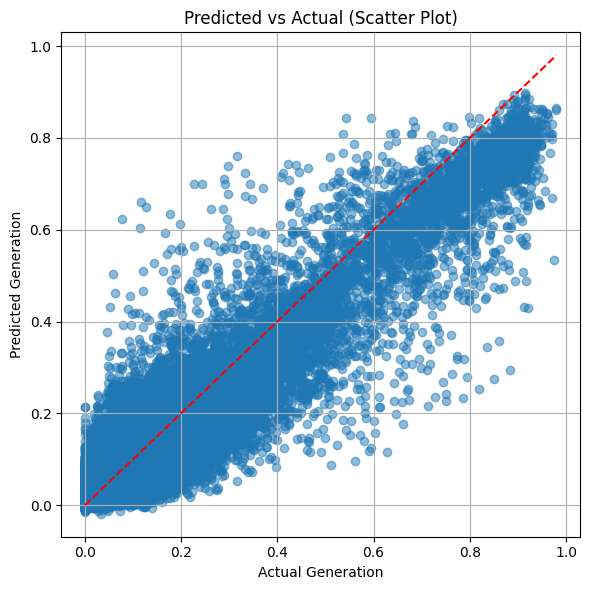

In [31]:
plt.figure(figsize=(6, 6))
plt.scatter(targets, preds, alpha=0.5)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--')
plt.title("Predicted vs Actual (Scatter Plot)")
plt.xlabel("Actual Generation")
plt.ylabel("Predicted Generation")
plt.grid(True)
plt.tight_layout()
plt.show()
